# Notes:
* IDs in dm_apps do not conflict with these IDs
    * confirm prior to import to full production Db
    * ALT: redo ID with another format
        * Kevin opinion: it would be nice to have the IDs look completely different between species for readability, but there may be reasons why 12-13 character ids are impractical
    * NB: since dates and sites are encoded into these ID, they may not be compatible with int filetypes
        * dm_apps looks to use char fields with max_length of 100, so should be fine... confirm
* CONFIRM: 
    * format of null samples when unmatched with fish details or length frequencies
    * required distict sample entry to link to for
        * fish details
        * length frequencies
    * no need for null fish details or length frequencies when unmatched with sample data
* WISHLIST
    * in dm_apps, it would be cool to be able to merge samples, or link with details/lengths (to deal with ambiguous data / partial matches)
    * in dm_apps, can we search for lengths/details, or do we need to find the correct sample?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
df_FD = pd.read_pickle('cleaned_MASTER_dataset.pickle')  # fish details
df_LF = pd.read_pickle('cleaned_LENGTHFREQ_dataset.pickle')  # length frequencies
df_SD = pd.read_pickle('cleaned_LOGBOOK_dataset.pickle')  # logbook / sample data

# Generate Unique IDs - Length Frequencies

In [3]:
# replace non-numeric data with made up site numbers
id_replacements = {
    '1A': 90,
    '1B': 91,
    'EricMcFarlane': 92,
    'JimmyMacFarlane': 93,
    'JohnAlbertCoady': 94
}
# df_LF.loc[df_LF.SITE1.isnull(), 'SITE1'] = 0  # set missing sites to 0
# NOTE: null sites can be set during query (fillna(0))
df_LF = df_LF.replace({'SITE1': id_replacements})

In [4]:
# 'unique' id column (note ambiguities, and solve later)
df_LF['id'] = (
    df_LF.DATETIME.dt.year*1_000_000 
    + df_LF.DATETIME.dt.month*10_000 
    + df_LF.DATETIME.dt.day*100 
    + df_LF.SITE1.fillna(0).astype(int)
).astype('Int64')

# new sample indicator
df_LF['new_sample'] = df_LF.lgth.diff() < 0

# new id indicator
df_LF['new_id'] = df_LF.id.diff() != 0

In [5]:
# update ids for ambiguous entries
duplicated_ids_LF = list(df_LF[~df_LF.new_id & df_LF.new_sample].id)

In [6]:
# only run this once
if df_LF.id.max() < 2_100_000_000:

    # add 1B to duplicate ids
    df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] = df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] + 1_000_000_000

    # add an extra billion to every other id, so that all are now distinct
    previous_lgth = 0
    multiplier = False

    for i, row in df_LF[df_LF.id > 2_900_000_000].iterrows():

        current_lgth = row['lgth']
        if previous_lgth > current_lgth:
            multiplier = not multiplier

        df_LF.loc[i, 'id'] = row.id + 1_000_000_000*multiplier

        previous_lgth = current_lgth

In [7]:
# LOOKS GOOD: check to see if it worked
df_LF[df_LF.id.isin([x + 1_000_000_000 for x in duplicated_ids_LF]) | df_LF.id.isin([x + 2_000_000_000 for x in duplicated_ids_LF])]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id
3102,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,235,1,235,1998-05-01,5,<NA>,<NA>,2998050105,True,True
3103,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,240,1,240,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3104,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,245,4,245,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3105,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,250,2,250,1998-05-01,5,<NA>,<NA>,2998050105,False,False
3106,1998,5,1,NaN,SW MARGAREE,1,5,LOWER,PM,10.000,4.500,255,3,255,1998-05-01,5,<NA>,<NA>,2998050105,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10848,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,250,25,250,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10849,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,255,13,255,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10850,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,260,1,260,2018-06-13,64,<NA>,<NA>,3018061364,False,False
10851,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,235,2,235,2018-06-13,64,<NA>,<NA>,4018061364,True,False


In [8]:
# GOOD:
df_LF[df_LF.id.isin(duplicated_ids_LF)]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id


# Length Bins

In [9]:
# use the same bins as used in the herring database
df_LF['length_bin_id'] = (df_LF.lgth - df_LF.lgth % 5) / 10

In [10]:
# error check: how many total fish cm (binned)
(df_LF['length_bin_id'] * df_LF['freq']).sum()

5076496.0

In [11]:
gaspereau_lengthfrequency = df_LF.groupby(['id', 'length_bin_id']).sum('freq').reset_index()[['freq', 'length_bin_id', 'id']].rename({
    'freq': 'count', 
    'length_bin_id': 'length_bin_id', 
    'id': 'sample_id'
}, axis=1)

In [12]:
# LOOKS GOOD: error check: how many total fish cm (binned)
(gaspereau_lengthfrequency['length_bin_id'] * gaspereau_lengthfrequency['count']).sum()

5076496.0

In [13]:
# lets look at a few histograms, just to check
sample_ids = gaspereau_lengthfrequency.sample_id.unique()

----------------------------------------------
Histogram: 1995061235


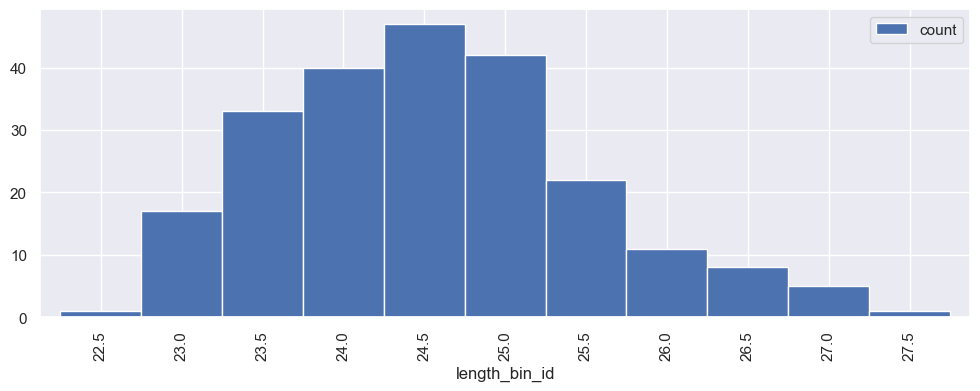

----------------------------------------------
Histogram: 2001052641


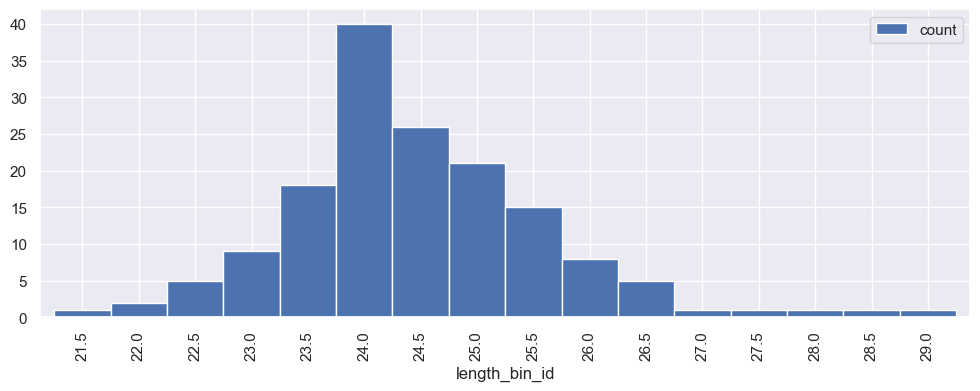

----------------------------------------------
Histogram: 2019052862


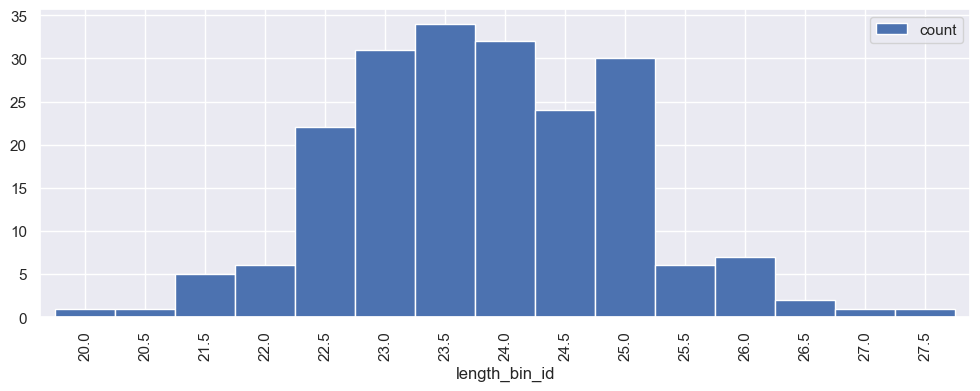

----------------------------------------------
Histogram: 1991053035


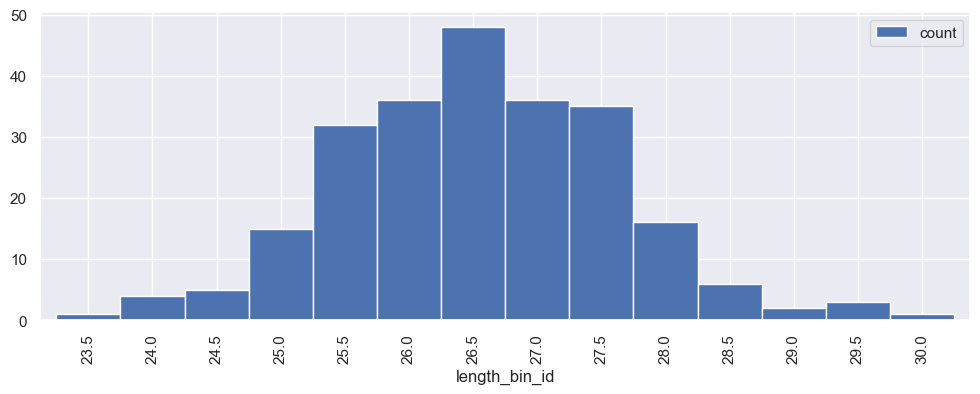

----------------------------------------------
Histogram: 2001051826


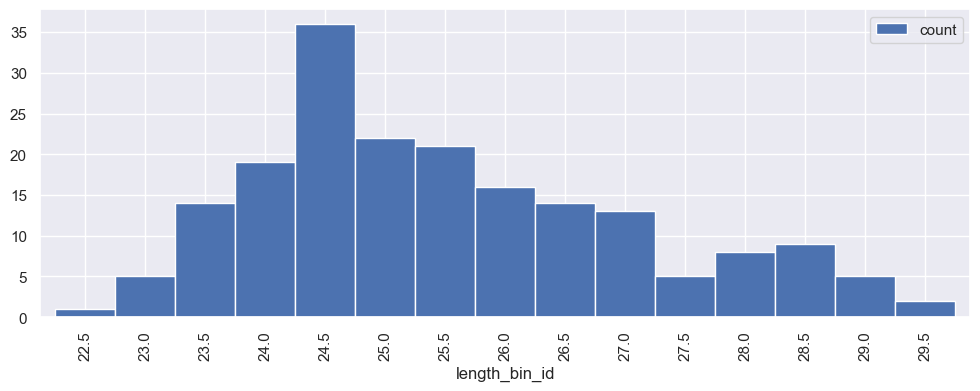

In [14]:
# random samples - check the histogram
for i in range(5):
    sample_id = np.random.choice(sample_ids)
    print('----------------------------------------------\nHistogram:', sample_id)
    gaspereau_lengthfrequency.loc[gaspereau_lengthfrequency.sample_id==sample_id, ['count', 'length_bin_id']].plot(kind='bar', x='length_bin_id', y='count', width=1, figsize=(12,4))
    plt.show()

# Samples

In [15]:
# same site replacements from LF
df_SD = df_SD.replace({'SITE1': id_replacements})

# 'unique' id column
df_SD['id'] = (
    df_SD.YEAR.astype(int)*1_000_000 
    + df_SD.MM.fillna(0).astype(int)*10_000
    + df_SD.DD.fillna(0).astype(int)*100
    + df_SD.SITE1.fillna(0).astype(int)
).astype('Int64')

# duplicated ids
duplicated_ids_SD = set(df_SD[df_SD.duplicated('id', keep=False)].id)

In [16]:
# some of these ids end up with an extra digit
if df_SD.id.max() < 2_100_000_000:
    
    # initialise number of handled repeats as zero for each id
    n_repeats = dict(zip(duplicated_ids_SD, [0 for x in duplicated_ids_SD]))
    
    for i, row in df_SD[df_SD.id.isin(duplicated_ids_SD)].iterrows():
        df_SD.loc[i, 'id'] = row['id'] + 1_000_000_000 * int(n_repeats[row['id']] + 1)
        n_repeats[row['id']] += 1

In [17]:
# check to see if it worked
check_SD = set()
for idx in list(df_SD[df_SD.id > 2_100_000_000].id):
    check_SD.add(idx % 1_000_000_000)

# looks good
check_SD, duplicated_ids_SD

({4061001, 988040037, 988052348, 997061258},
 {1988040037, 1988052348, 1997061258, 2004061001})

In [18]:
# another check, looks good
df_SD[df_SD.id > 2_100_000_000]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
2346,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,36076.000,16363.800,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,2988040037
2452,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1988,5,23,<NA>,7015.000,3182.000,13,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-23,2988052348
2531,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,4008.000,1818.000,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,3988040037
2535,2,SWMARG,Michael D Gillis,NaN,81,48,NaN,1988,5,23,<NA>,4008.000,1818.000,13,upper,Gillis,NaN,NaN,NaN,NaN,48,<NA>,1988-05-23,3988052348
2570,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,3006.000,1363.500,12,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,4988040037
2571,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,3006.000,1363.500,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,5988040037
2608,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,2405.000,1090.900,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,6988040037
2633,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,2004.000,909.000,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,7988040037
2680,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,1503.000,681.700,12,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,8988040037
2731,2,SWMARG,Donald J Gillis,NaN,81,37,NaN,1988,4,<NA>,<NA>,1002.000,454.500,14,upper,Gillis,NaN,NaN,NaN,NaN,37,<NA>,NaT,9988040037


In [19]:
# perfect
df_SD[df_SD.duplicated('id')]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id


# add null sample data where there is unmatched length frequencies

In [20]:
# how many length frequency measurements are matched with samples?
# apprx 80%
(
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique(), 
    df_LF.id.nunique(), 
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique() / df_LF.id.nunique()
)

(731, 917, 0.797164667393675)

In [21]:
# add null samples where no match exists
df_SD = pd.concat([df_SD, pd.DataFrame(df_LF[~df_LF.id.isin(set(df_SD.id))].id.unique(), columns=['id'])]).reset_index(drop=True)

# NOTE: if a datetime column is useful, pd.to_datetime(id // 100) should work
# alt could use a more complicated JOIN to add SITE1 as well
# leave this way for now

In [22]:
# all LF data are in the SD dataframe
df_LF[~df_LF.id.isin(set(df_SD.id))]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id


# fishdetails IDs

In [23]:
df_FD.SITE.unique()

array(['12', '8', '17', '33', '5', '9', '25', '2', '64', '15', '49', '56',
       nan, '7', '11', '35', '38', '39', '51', '37', '46', '48', '34',
       '4', '23', '67', '1', '26', '28', '6', '52', '29', '1A', '60',
       '60, 52', '41', '1, 8', '37,38,35', '60,52', '1,8', '5,8', '12,17',
       '15,17', '33,48,49', '11,12', '5,11,17', '37,60', '52,60', '38,52',
       '1,8,26', '33,41,60', '35,60', '27', '35,37', '01,02', '41,49',
       '52,60,38', '60,52,35', '41,35', '60,41', '35,41', '38,60,52',
       '49,41', '35,52', '12,26', '2,5', '5,17', '5,26', '25,26', '47',
       '14', '30', '62', '47 or 62', '11K3 (435,211)', 'E.MACFARLANE',
       'Eric MacFarlane', 'JA Coady', 'J McFarlane'], dtype=object)

In [24]:
# replace non-numeric data with made up site numbers
id_replacements_v2 = {
    '1A': 90,
    '1B': 91,
    'Eric MacFarlane': 92,
    'E.MACFARLANE': 92,
    'J McFarlane': 93,
    'JA Coady': 94,
    '11K3 (435,211)': 95, 
    '47 or 62': 47
}

In [25]:
# same site replacements from LF
df_FD['SITE1'] = df_FD.replace({'SITE': id_replacements_v2}).SITE
df_FD[['SITE1', 'SITE2', 'SITE3']] = df_FD.SITE1.str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

df_FD['sample_id'] = (
    df_FD.YEAR.astype(int)*1_000_000 
    + df_FD.MM.fillna(0).astype(int)*10_000
    + df_FD.DD.fillna(0).astype(int)*100
    + df_FD.SITE1.fillna(0).astype(int)
).astype('Int64')

# add null sample data where there is unmatched fish details

In [26]:
# how many fish detail sample ids are matched with samples id column?
# apprx 95%
(
    df_FD[df_FD.sample_id.isin(set(df_SD.id))].sample_id.nunique(), 
    df_FD.sample_id.nunique(), 
    df_FD[df_FD.sample_id.isin(set(df_SD.id))].sample_id.nunique() / df_FD.sample_id.nunique()
)

(1052, 1106, 0.9511754068716094)

In [27]:
df_SD = pd.concat([df_SD, pd.DataFrame(df_FD[~df_FD.sample_id.isin(set(df_SD.id))].sample_id.unique(), columns=['id'])]).reset_index(drop=True)
# again, a few more details could be added, but leave for now because the sample data is incomplete either way

In [28]:
# check SD for missing FD data
df_FD[~df_FD.sample_id.isin(set(df_SD.id))].sample_id.unique()

<IntegerArray>
[]
Length: 0, dtype: Int64

In [29]:
# looks good
df_FD.sample(10)

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME,SITE1,SITE2,SITE3,sample_id
8543,1990,5,25,<NA>,2,PM,Frozen,41,<NA>,243,251.000,243.000,A,F,4,38.500,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,1990-05-25,2,<NA>,<NA>,1990052502
2493,1986,4,28,<NA>,12,NaN,Frozen,4,<NA>,250,258.000,233.000,A,M,2,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,1986-04-28,12,<NA>,<NA>,1986042812
13428,1995,6,6,6,26,AM,Frozen,19,<NA>,276,284.000,328.000,A,F,4,70.300,NaN,5,4,NaN,NaN,<NA>,<NA>,NaN,NaN,5,4,1995-06-06,26,<NA>,<NA>,1995060626
18138,2000,6,2,5,5,AM,Frozen,8,<NA>,240,248.000,187.000,A,M,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2000-06-02,5,<NA>,<NA>,2000060205
5745,1989,5,25,<NA>,64,AM,Frozen,31,<NA>,265,273.000,260.000,A,M,4,NaN,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1989-05-25,64,<NA>,<NA>,1989052564
12936,1994,6,13,<NA>,33,AM,Frozen,3,<NA>,215,223.000,125.000,B,M,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1994-06-13,33,<NA>,<NA>,1994061333
31322,2016,5,10,2,33,PM,Fresh,6,237,<NA>,237.000,176.500,A,M,4,NaN,JM,4,3,Couple good,NaN,<NA>,<NA>,NaN,NaN,4,3,2016-05-10,33,<NA>,<NA>,2016051033
9291,1990,6,8,<NA>,64,AM,Fresh,1,258,<NA>,258.000,228.000,A,F,3,18.400,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,1990-06-08,64,<NA>,<NA>,1990060864
17660,2000,5,20,3,26,AM,Frozen,7,<NA>,229,237.000,166.000,A,M,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2000-05-20,26,<NA>,<NA>,2000052026
3459,1987,5,21,<NA>,12,NaN,Frozen,24,<NA>,223,231.000,209.000,A,U,2,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,1987-05-21,12,<NA>,<NA>,1987052112


# format tables for saving

### SAMPLE DATA

In [30]:
"""uses all sample-related data available - doesn't match well with herring_sample table"""

# ALL CAPS FOR UNMATCHED / NEW
rename_SD = {
    'DATETIME': 'sample_date', 'DIST': 'district_id', 'RIVER': 'fishing_area_id', 
    'NAME': 'SAMPLER', 'code': 'CODE', 'GEAR': 'gear_id', 'SITE1': 'SITE',
    'no_nets': 'NO_NETS', 'catch_lbs': 'catch_weight_lbs', 'hours_fished': 'HOURS_FISHED', 
    'zone': 'ZONE', 'last_name': 'LAST_NAME', 'comments': 'remarks',
    'bycatch_sbass': 'BYCATCH_SBASS', 'bycatch_shad': 'BYCATCH_SHAD', 'bycatch_other': 'BYCATCH_OTHER', 
    'wt_lbs': 'sample_weight_lbs'
}

gaspereau_sample = pd.merge(
    df_SD[[
        'id', 'DATETIME', 'DIST', 'RIVER', 'NAME', 'code', 'GEAR', 'SITE1', 'no_nets', 'catch_lbs', 'hours_fished', 
        'zone', 'last_name', 'comments', 'bycatch_sbass', 'bycatch_shad', 'bycatch_other'
    ]], 
    df_LF[['id', 'wt_lbs']],
    on='id', 
    how='left'  # all samples 
).drop_duplicates().reset_index(drop=True).rename(columns=rename_SD)

In [31]:
gaspereau_sample.sample(5)

,id,sample_date,district_id,fishing_area_id,SAMPLER,CODE,gear_id,SITE,NO_NETS,catch_weight_lbs,HOURS_FISHED,ZONE,LAST_NAME,remarks,BYCATCH_SBASS,BYCATCH_SHAD,BYCATCH_OTHER,sample_weight_lbs
10730,2008060741,2008-06-07,2.000,SWMARG,Stewart Gillis,NaN,81.000,41,1,20000.000,14,upper,Gillis,NaN,NaN,NaN,NaN,133.000
8188,2001061448,2001-06-14,2.000,SWMARG,Michael D Gillis,NaN,81.000,48,1,200.000,5,upper,Gillis,NaN,NaN,NaN,NaN,NaN
5401,1993052637,1993-05-26,2.000,SWMARG,Florence Gillis,NaN,81.000,37,NaN,250.000,7.5,upper,Gillis,NaN,NaN,NaN,NaN,NaN
3292,1989051201,1989-05-12,2.000,SWMARG,Marilyn Gillis,NaN,81.000,1,NaN,1001.000,12,lower,Gillis,NaN,NaN,NaN,NaN,NaN
6237,1995061634,1995-06-16,2.000,SWMARG,Fred Ingram,NaN,81.000,34,1,0.000,8,upper,Ingram,NaN,NaN,NaN,NaN,NaN


### Fish Details

In [32]:
"""uses all detail-related data available - doesn't match well with herring_fishdetail table"""

# ALL CAPS used for unmatched fields
rename_FD = {
    'SITE1': 'SITE', 'FISH_NO': 'fish_number', 'FL_STD': 'fish_length', 
    'WEIGHT': 'fish_weight', 'MATURITY': 'maturity_id',
    'GONAD_WEIGHT': 'gonad_weight', '1st Person Aging': 'AGING_PERSON_1', 'AGE': 'AGE_1', 'FSP': 'FSP_1', 
    'Comments': 'AGE_COMMENTS_1', '2nd Person Aging': 'AGING_PERSON_2', 'AGE.1': 'AGE_2', 'FSP.1': 'FSP_2', 
    'Comments.1': 'AGE_COMMENTS_2', 'Envelop Comments': 'remarks', 'AGE_notes': 'AGE_NOTES', 'FSP_notes': 'FSP_NOTES'
}

gaspereau_fishdetails = df_FD[[
    'sample_id','DATETIME', 'SITE1',
    'CONDITION', 'FISH_NO', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'WEIGHT', 'SPECIES', 'SEX', 'MATURITY', 
    'GONAD_WEIGHT', '1st Person Aging', 'AGE', 'FSP', 'Comments', '2nd Person Aging', 'AGE.1', 'FSP.1', 'Comments.1', 
    'Envelop Comments', 'AGE_notes', 'FSP_notes'
]].rename(columns=rename_FD)

In [33]:
gaspereau_fishdetails.sample(5)

,sample_id,DATETIME,SITE,CONDITION,fish_number,FL_WET,FL_FROZEN,fish_length,fish_weight,SPECIES,SEX,maturity_id,gonad_weight,AGING_PERSON_1,AGE_1,FSP_1,AGE_COMMENTS_1,AGING_PERSON_2,AGE_2,FSP_2,AGE_COMMENTS_2,remarks,AGE_NOTES,FSP_NOTES
17407,2000051705,2000-05-17,5,Frozen,19,<NA>,224,232.000,151.300,A,M,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3
31165,2015062625,2015-06-26,25,Frozen,1,<NA>,215,223.000,122.200,B,M,3,NaN,JM,3,3,Clear,NaN,<NA>,<NA>,NaN,NaN,3,3
24677,2010051241,2010-05-12,41,Fresh,14,272,<NA>,272.000,163.800,A,F,4,34.400,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4
24128,2009060205,2009-06-02,5,Fresh,1,227,<NA>,227.000,143.000,A,M,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3
24396,2009061041,2009-06-10,41,Fresh,16,250,<NA>,250.000,191.100,A,M,4,NaN,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3


# Save Tables

In [34]:
# this can link to herring_lengthbin (it goes from 0 to 200cm - more than enough)
if True:  # change this to overwrite/resave
    gaspereau_lengthfrequency.to_pickle('gaspereau_lengthfrequency.pickle')
    gaspereau_fishdetails.to_pickle('gaspereau_fishdetails.pickle')
    gaspereau_sample.to_pickle('gaspereau_sample.pickle')

In [35]:
gaspereau_lengthfrequency.sample(5)

,count,length_bin_id,sample_id
850,2,29.000,1991053009
9530,10,21.000,2016062100
1160,42,25.000,1992060217
10304,14,25.000,2018062325
2966,6,26.000,1995061941


In [36]:
gaspereau_fishdetails.sample(5)

,sample_id,DATETIME,SITE,CONDITION,fish_number,FL_WET,FL_FROZEN,fish_length,fish_weight,SPECIES,SEX,maturity_id,gonad_weight,AGING_PERSON_1,AGE_1,FSP_1,AGE_COMMENTS_1,AGING_PERSON_2,AGE_2,FSP_2,AGE_COMMENTS_2,remarks,AGE_NOTES,FSP_NOTES
2078,1985052612,1985-05-26,12,Frozen,9,<NA>,254,262.000,223.000,A,M,2,NaN,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4
20976,2003052926,2003-05-29,26,Fresh,28,241,<NA>,241.000,174.100,A,M,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3
8611,1990052709,1990-05-27,9,Frozen,23,<NA>,268,276.000,306.000,A,F,4,45.100,NaN,5,4,NaN,NaN,<NA>,<NA>,NaN,NaN,5,4
27673,2012062241,2012-06-22,41,Fresh,24,243,<NA>,243.000,154.700,B,M,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN
32210,2016062447,2016-06-24,47,Fresh,8,223,<NA>,223.000,109.800,A,M,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN


In [37]:
gaspereau_sample.sample(5)

,id,sample_date,district_id,fishing_area_id,SAMPLER,CODE,gear_id,SITE,NO_NETS,catch_weight_lbs,HOURS_FISHED,ZONE,LAST_NAME,remarks,BYCATCH_SBASS,BYCATCH_SHAD,BYCATCH_OTHER,sample_weight_lbs
10143,2006062041,2006-06-20,2.000,SWMARG,Stewart Gillis,NaN,81.000,41,1,600.000,7,upper,Gillis,NaN,NaN,NaN,NaN,NaN
2501,1988052417,1988-05-24,2.000,SWMARG,John A Chisholm,NaN,81.000,17,NaN,5011.000,16,lower,Chisholm,NaN,NaN,NaN,NaN,NaN
2399,1988052633,1988-05-26,2.000,SWMARG,Michael J Stewart,NaN,81.000,33,NaN,15032.000,15,upper,Stewart,NaN,NaN,NaN,NaN,NaN
9080,2004051441,2004-05-14,2.000,SWMARG,Stewart Gillis,NaN,81.000,41,1,300.000,8,upper,Gillis,NaN,NaN,NaN,NaN,NaN
554,1984060435,1984-06-04,2.000,SWMARG,John MacLellan,NaN,81.000,35,NaN,501.000,12,upper,MacLellan,NaN,NaN,NaN,NaN,NaN


# QA CHECKS
* check one, dates seem consistent between LF and FD
* check two, only one discrepancy, but seems like a typo/clerical error
* check three, scrambled data works much worse, dates look coherent
* check four, sample weight match much better than scrambled dates would

**CONCLUSION**: dates look consistent between tables (should still confirm prior to import/merging data)

### check 1

In [35]:
#TODO: figure out if year, mm, dd is the day the sample was collected. IF NOT SAMPLE_ID IS WRONG
df_FD.sample(5)

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME,SITE1,SITE2,SITE3,sample_id
12429,1994,5,27,<NA>,"1,8,26",PM,Frozen,3,<NA>,253,261.000,228.000,A,M,4,NaN,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,1994-05-27,1,8,26,1994052701
35097,2019,6,19,8,12,AM,Frozen,16,<NA>,<NA>,NaN,211.000,A,F,4,25.800,JM,4,4,4-3 IF BB,NaN,<NA>,<NA>,NaN,NaN,4,4,2019-06-19,12,<NA>,<NA>,2019061912
31079,2015,6,23,9,12,PM,Frozen,11,<NA>,234,242.000,180.100,A,F,3,22.900,JM,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2015-06-23,12,<NA>,<NA>,2015062312
5974,1989,5,19,<NA>,7,AM,Frozen,38,<NA>,275,283.000,306.000,A,F,4,49.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1989-05-19,7,<NA>,<NA>,1989051907
33917,2018,6,5,6,25,PM,Frozen,13,<NA>,234,242.000,143.600,A,M,4,NaN,JM,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,2018-06-05,25,<NA>,<NA>,2018060525


In [36]:
df_LF.sample(5)

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
9674,2017,5,18,NaN,MARGAREE,3,41,UPPER,PM,84.500,38.300,240,43,240,2017-05-18,41,<NA>,<NA>,2017051841,False,False,24.000
5825,2007,5,8,NaN,SW MARGAREE,2,26,LOWER,PM,146.000,66.200,270,31,270,2007-05-08,26,<NA>,<NA>,2007050826,False,False,27.000
5333,2003,6,6,NaN,SW MARGAREE,6,41,UPPER,PM,111.000,50.300,250,33,250,2003-06-06,41,<NA>,<NA>,2003060641,False,False,25.000
6253,2008,6,14,NaN,SW MARGAREE,7,26,LOWER,PM,125.000,56.700,260,7,260,2008-06-14,26,<NA>,<NA>,2008061426,False,False,26.000
2363,1995,6,9,NaN,SW MARGAREE,6,12,LOWER,AM,141.500,64.200,270,6,270,1995-06-09,12,<NA>,<NA>,1995060912,False,False,27.000


In [37]:
# 73% matches from details to length frequencies
df_FD[df_FD.sample_id.isin(df_LF.id.unique())].sample_id.nunique() / df_FD.sample_id.nunique()

0.72875226039783

In [38]:
# if everything is good, this should never happen (unless typos, etc)

QACHECK = pd.merge(
    pd.DataFrame(df_FD.groupby('sample_id').sum()['WEIGHT'].reset_index()),
    pd.DataFrame(df_LF.groupby('id').min()['wt_kg'])*1000,
    left_on='sample_id',
    right_on='id'
).rename(columns={'wt_kg': 'wt_g'})
QACHECK[QACHECK['WEIGHT'] > QACHECK['wt_g']]

,sample_id,WEIGHT,wt_g
156,1995052338,5121.000,5000.000


In [39]:
# one exception, let's check it out
df_FD[df_FD.sample_id==1995052338]

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME,SITE1,SITE2,SITE3,sample_id
13812,1995,5,23,4,38,AM,Frozen,1,<NA>,276,284.000,322.000,A,F,4,71.700,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-05-23,38,<NA>,<NA>,1995052338
13813,1995,5,23,4,38,AM,Frozen,2,<NA>,253,261.000,232.000,A,M,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-05-23,38,<NA>,<NA>,1995052338
13814,1995,5,23,4,38,AM,Frozen,3,<NA>,236,243.000,175.000,A,M,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-05-23,38,<NA>,<NA>,1995052338
13815,1995,5,23,4,38,AM,Frozen,4,<NA>,246,254.000,217.000,A,F,4,31.100,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-05-23,38,<NA>,<NA>,1995052338
13816,1995,5,23,4,38,AM,Frozen,5,<NA>,248,256.000,206.000,A,M,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-05-23,38,<NA>,<NA>,1995052338
13817,1995,5,23,4,38,AM,Frozen,6,<NA>,258,266.000,265.000,A,M,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-05-23,38,<NA>,<NA>,1995052338
13818,1995,5,23,4,38,AM,Frozen,7,<NA>,243,251.000,206.000,A,M,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-05-23,38,<NA>,<NA>,1995052338
13819,1995,5,23,4,38,AM,Frozen,8,<NA>,263,271.000,276.000,A,M,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-05-23,38,<NA>,<NA>,1995052338
13820,1995,5,23,4,38,AM,Frozen,9,<NA>,278,287.000,347.000,A,F,4,69.600,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-05-23,38,<NA>,<NA>,1995052338
13821,1995,5,23,4,38,AM,Frozen,10,<NA>,238,246.000,204.000,A,F,4,29.800,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-05-23,38,<NA>,<NA>,1995052338


In [40]:
df_LF[df_LF.id==1995052338]

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
2470,1995,5,23,NaN,SW MARGAREE,4,38,UPPER,AM,11.000,5.000,240,1,240,1995-05-23,38,<NA>,<NA>,1995052338,True,True,24.000
2471,1995,5,23,NaN,SW MARGAREE,4,38,UPPER,AM,11.000,5.000,245,2,245,1995-05-23,38,<NA>,<NA>,1995052338,False,False,24.500
2472,1995,5,23,NaN,SW MARGAREE,4,38,UPPER,AM,11.000,5.000,250,3,250,1995-05-23,38,<NA>,<NA>,1995052338,False,False,25.000
2473,1995,5,23,NaN,SW MARGAREE,4,38,UPPER,AM,11.000,5.000,255,1,255,1995-05-23,38,<NA>,<NA>,1995052338,False,False,25.500
2474,1995,5,23,NaN,SW MARGAREE,4,38,UPPER,AM,11.000,5.000,260,2,260,1995-05-23,38,<NA>,<NA>,1995052338,False,False,26.000
2475,1995,5,23,NaN,SW MARGAREE,4,38,UPPER,AM,11.000,5.000,265,3,265,1995-05-23,38,<NA>,<NA>,1995052338,False,False,26.500
2476,1995,5,23,NaN,SW MARGAREE,4,38,UPPER,AM,11.000,5.000,270,2,270,1995-05-23,38,<NA>,<NA>,1995052338,False,False,27.000
2477,1995,5,23,NaN,SW MARGAREE,4,38,UPPER,AM,11.000,5.000,275,1,275,1995-05-23,38,<NA>,<NA>,1995052338,False,False,27.500
2478,1995,5,23,NaN,SW MARGAREE,4,38,UPPER,AM,11.000,5.000,280,4,280,1995-05-23,38,<NA>,<NA>,1995052338,False,False,28.000
2479,1995,5,23,NaN,SW MARGAREE,4,38,UPPER,AM,11.000,5.000,285,1,285,1995-05-23,38,<NA>,<NA>,1995052338,False,False,28.500


In [41]:
# total of 20 fish, 5kg is reasonable
df_LF[df_LF.id==1995052338].freq.sum()

20

In [42]:
# 20 fish 
df_FD[df_FD.sample_id==1995052338].FISH_NO.max()

20

In [43]:
# it looks like this example, every fish with lengths got detailed (only 20)
# also, 5120g is approx 5 kg, so this looks correct

In [44]:
# check all values
QACHECK = pd.merge(
    pd.DataFrame(df_FD.groupby('sample_id')['WEIGHT'].sum().reset_index()),
    pd.DataFrame(df_LF.groupby('id')['wt_kg'].min())*1000,
    left_on='sample_id',
    right_on='id'
).rename(columns={'wt_kg': 'wt_g'})

QACHECK['QA_RATIO'] = QACHECK['WEIGHT'] / QACHECK['wt_g']

QACHECK.describe()

,sample_id,WEIGHT,wt_g,QA_RATIO
count,806.000,806.000,741.000,741.000
mean,2004936873.865,6762.871,45984.793,0.164
std,9158544.932,2078.022,15680.514,0.104
min,1990050805.000,0.000,1400.000,0.000
25%,1996060220.000,5414.325,36700.000,0.117
50%,2004061030.000,6321.100,44500.000,0.138
75%,2013061841.750,7641.075,56700.000,0.166
max,2019062841.000,18094.000,92500.000,1.024


### check 2

In [45]:
#TODO: one more QA check
# COMPARE FISH COUNTS BETWEEN DETAILS AND LENGTH FREQUENCIES

QACHECK = pd.merge(
    pd.DataFrame(df_FD.groupby('sample_id')['FISH_NO'].max().reset_index()),
    pd.DataFrame(df_LF.groupby('id')['freq'].sum()),
    left_on='sample_id',
    right_on='id'
).rename(columns={'FISH_NO': 'FD_count', 'freq': 'LF_count'})

QACHECK['QA_RATIO'] = QACHECK['FD_count'] / QACHECK['LF_count']

QACHECK.describe()

,sample_id,FD_count,LF_count,QA_RATIO
count,806.000,806.000,806.000,806.000
mean,2004936873.865,32.619,227.645,0.178
std,9158544.932,6.551,68.715,0.288
min,1990050805.000,6.000,4.000,0.039
25%,1996060220.000,29.000,210.000,0.120
50%,2004061030.000,32.000,231.000,0.140
75%,2013061841.750,36.750,263.750,0.170
max,2019062841.000,63.000,542.000,7.750


In [46]:
# only 1 error, let's take a look
QACHECK[QACHECK.QA_RATIO > 1]

,sample_id,FD_count,LF_count,QA_RATIO
437,2007060235,31,4,7.750


In [47]:
display(df_LF[df_LF.id == 2007060235])
display(df_FD[df_FD.sample_id == 2007060235])

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
5962,2007,6,2,NaN,SW MARGAREE,5,35,UPPER,PM,122.000,55.300,225,4,225,2007-06-02,35,<NA>,<NA>,2007060235,True,True,22.500


,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME,SITE1,SITE2,SITE3,sample_id
22820,2007,6,2,5,35,PM,Frozen,1,<NA>,232,240.000,176.400,A,M,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,35,<NA>,<NA>,2007060235
22821,2007,6,2,5,35,PM,Frozen,2,<NA>,238,246.000,193.200,A,F,4,28.600,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,35,<NA>,<NA>,2007060235
22822,2007,6,2,5,35,PM,Frozen,3,<NA>,235,243.000,175.500,A,F,4,26.800,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,35,<NA>,<NA>,2007060235
22823,2007,6,2,5,35,PM,Frozen,4,<NA>,270,278.000,298.300,A,F,4,55.200,NaN,5,4,NaN,NaN,<NA>,<NA>,NaN,NaN,5,4,2007-06-02,35,<NA>,<NA>,2007060235
22824,2007,6,2,5,35,PM,Frozen,5,<NA>,254,262.000,227.700,A,F,4,39.300,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,2007-06-02,35,<NA>,<NA>,2007060235
22825,2007,6,2,5,35,PM,Frozen,6,<NA>,251,259.000,225.200,A,F,4,34.200,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,35,<NA>,<NA>,2007060235
22826,2007,6,2,5,35,PM,Frozen,7,<NA>,225,233.000,158.500,A,M,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,35,<NA>,<NA>,2007060235
22827,2007,6,2,5,35,PM,Frozen,8,<NA>,245,253.000,210.000,A,F,4,29.800,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,35,<NA>,<NA>,2007060235
22828,2007,6,2,5,35,PM,Frozen,9,<NA>,217,225.000,146.200,A,M,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,35,<NA>,<NA>,2007060235
22829,2007,6,2,5,35,PM,Frozen,10,<NA>,254,262.000,237.900,A,F,4,38.700,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,2007-06-02,35,<NA>,<NA>,2007060235


In [48]:
# maybe the fishdetails have an incorrect site number?
# there is no site==2 in FD table, but enough in LF to explain the discrepancy
display(df_LF[df_LF.DATETIME == '2007-06-02'])
display(df_FD[df_FD.DATETIME == '2007-06-02'])

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
5962,2007,6,2,NaN,SW MARGAREE,5,35,UPPER,PM,122.000,55.300,225,4,225,2007-06-02,35,<NA>,<NA>,2007060235,True,True,22.500
5963,2007,6,2,NaN,SW MARGAREE,5,2,LOWER,PM,122.000,55.300,230,6,230,2007-06-02,2,<NA>,<NA>,2007060202,False,True,23.000
5964,2007,6,2,NaN,SW MARGAREE,5,2,LOWER,PM,122.000,55.300,235,26,235,2007-06-02,2,<NA>,<NA>,2007060202,False,False,23.500
5965,2007,6,2,NaN,SW MARGAREE,5,2,LOWER,PM,122.000,55.300,240,56,240,2007-06-02,2,<NA>,<NA>,2007060202,False,False,24.000
5966,2007,6,2,NaN,SW MARGAREE,5,2,LOWER,PM,122.000,55.300,245,47,245,2007-06-02,2,<NA>,<NA>,2007060202,False,False,24.500
5967,2007,6,2,NaN,SW MARGAREE,5,2,LOWER,PM,122.000,55.300,250,61,250,2007-06-02,2,<NA>,<NA>,2007060202,False,False,25.000
5968,2007,6,2,NaN,SW MARGAREE,5,2,LOWER,PM,122.000,55.300,255,22,255,2007-06-02,2,<NA>,<NA>,2007060202,False,False,25.500
5969,2007,6,2,NaN,SW MARGAREE,5,2,LOWER,PM,122.000,55.300,260,21,260,2007-06-02,2,<NA>,<NA>,2007060202,False,False,26.000
5970,2007,6,2,NaN,SW MARGAREE,5,2,LOWER,PM,122.000,55.300,265,10,265,2007-06-02,2,<NA>,<NA>,2007060202,False,False,26.500
5971,2007,6,2,NaN,SW MARGAREE,5,2,LOWER,PM,122.000,55.300,270,4,270,2007-06-02,2,<NA>,<NA>,2007060202,False,False,27.000


,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME,SITE1,SITE2,SITE3,sample_id
22788,2007,6,2,5,26,AM,Frozen,1,<NA>,255,263.000,226.600,A,M,4,NaN,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,2007-06-02,26,<NA>,<NA>,2007060226
22789,2007,6,2,5,26,AM,Frozen,2,<NA>,264,272.000,245.700,A,F,4,35.700,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,2007-06-02,26,<NA>,<NA>,2007060226
22790,2007,6,2,5,26,AM,Frozen,3,<NA>,258,266.000,268.700,A,F,4,49.300,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,2007-06-02,26,<NA>,<NA>,2007060226
22791,2007,6,2,5,26,AM,Frozen,4,<NA>,231,239.000,163.200,A,M,4,NaN,NaN,5,4,NaN,NaN,<NA>,<NA>,NaN,NaN,5,4,2007-06-02,26,<NA>,<NA>,2007060226
22792,2007,6,2,5,26,AM,Frozen,5,<NA>,274,282.000,322.300,A,F,4,54.000,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,26,<NA>,<NA>,2007060226
22793,2007,6,2,5,26,AM,Frozen,6,<NA>,226,234.000,164.500,A,F,4,18.500,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,26,<NA>,<NA>,2007060226
22794,2007,6,2,5,26,AM,Frozen,7,<NA>,224,232.000,169.100,A,M,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,26,<NA>,<NA>,2007060226
22795,2007,6,2,5,26,AM,Frozen,8,<NA>,271,279.000,304.600,A,F,4,56.500,NaN,6,3,NaN,NaN,<NA>,<NA>,NaN,NaN,6,3,2007-06-02,26,<NA>,<NA>,2007060226
22796,2007,6,2,5,26,AM,Frozen,9,<NA>,261,269.000,240.400,A,F,4,36.100,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,2007-06-02,26,<NA>,<NA>,2007060226
22797,2007,6,2,5,26,AM,Frozen,10,<NA>,227,235.000,166.900,A,M,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2007-06-02,26,<NA>,<NA>,2007060226


In [49]:
# looks like this is an error/typo, or miscommunication between fisher, or logbook issue, or maybe site 2 and 26 are similar
# overall, looks very much like a clerical error, and all other info looks good.

### check 3

In [50]:
# what are the chances that data is misordered but looks good anyway?
# try scrambing ids and redoing the above calcs

In [51]:
# check 1 - fish weights
pd.concat(
    [pd.DataFrame(df_FD.groupby('sample_id')['WEIGHT'].sum()).describe(percentiles=[0.01, 0.05, 0.25, .5, .75, .95, .99]).rename(columns={'WEIGHT': 'fishdetails'}),
    pd.DataFrame(df_LF.groupby('id')['wt_kg'].sum() * 1000).describe(percentiles=[0.01, 0.05, 0.25, .5, .75, .95, .99]).rename(columns={'wt_kg': 'length_frequency'})],
    axis=1
)

,fishdetails,length_frequency
count,1106.000,917.000
mean,6957.882,520122.665
std,2880.658,274476.576
min,0.000,0.000
1%,1394.600,0.000
5%,4108.400,0.000
25%,5289.200,393800.000
50%,6231.000,517000.000
75%,7754.975,668800.000
95%,12508.950,1013040.000


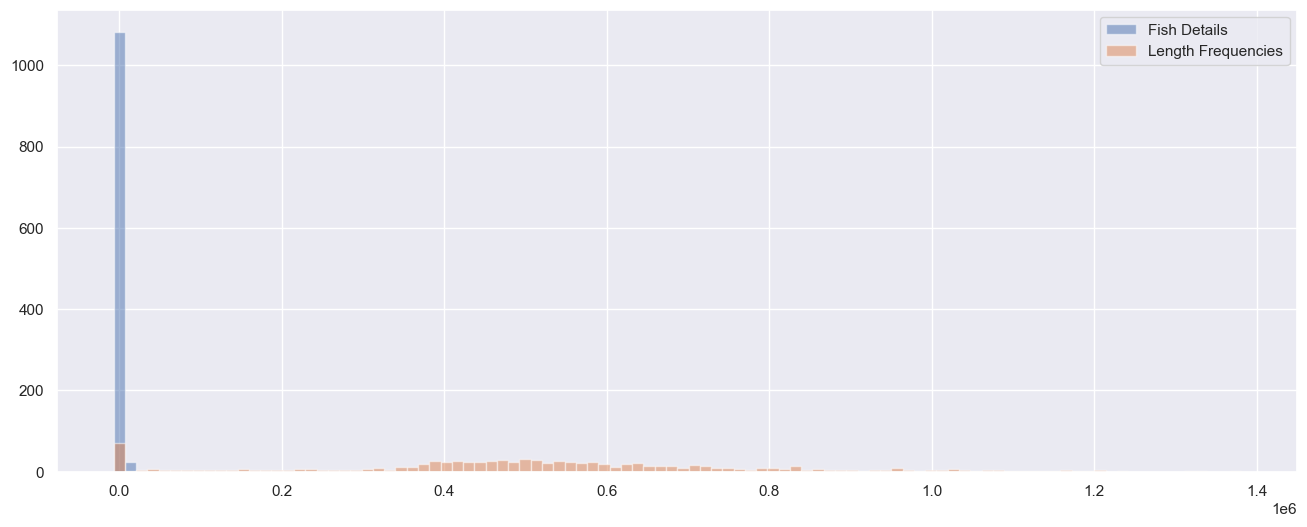

In [52]:
fig, ax = plt.subplots(figsize=(16, 6))
bins = 2

plt.hist(pd.DataFrame(df_FD.groupby('sample_id')['WEIGHT'].sum()), bins=bins, alpha=0.5, label='Fish Details', density=False, align='left')
plt.hist(pd.DataFrame(df_LF.groupby('id')['wt_kg'].sum() * 1000), bins=bins*50, alpha=0.5, label='Length Frequencies', density=False, align='left')

plt.legend(loc='upper right')

plt.show()

# about 5-10% zeros which would error, compared to ~1/10000
# therefore, the dates look coherent

In [53]:
# check 2 - fish counts
pd.concat(
    [pd.DataFrame(df_FD.groupby('sample_id')['FISH_NO'].max()).describe(percentiles=[0.01, 0.05, 0.25, .5, .75, .95, .99]).rename(columns={'FISH_NO': 'fishdetails'}),
    pd.DataFrame(df_LF.groupby('id')['freq'].sum()).describe(percentiles=[0.01, 0.05, 0.25, .5, .75, .95, .99]).rename(columns={'freq': 'length_frequency'})],
    axis=1
)

,fishdetails,length_frequency
count,1106.000,917.000
mean,31.922,223.897
std,9.071,70.905
min,2.000,2.000
1%,15.000,20.000
5%,20.000,67.000
25%,26.000,206.000
50%,31.000,230.000
75%,37.000,262.000
95%,47.000,321.000


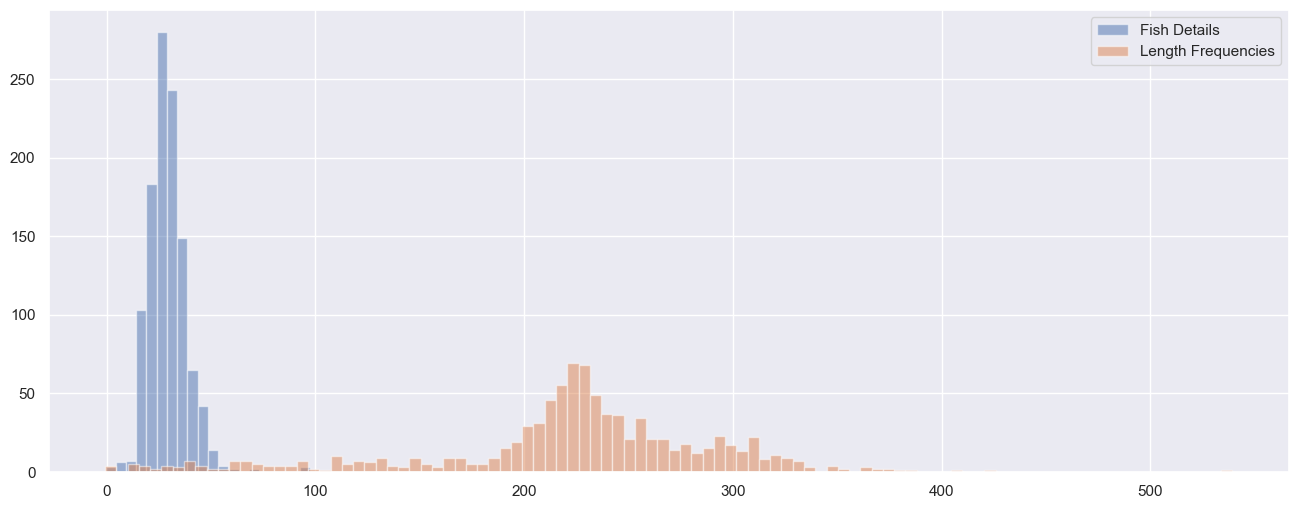

In [54]:
fig, ax = plt.subplots(figsize=(16, 6))
bins = 20

plt.hist(pd.DataFrame(df_FD.groupby('sample_id')['FISH_NO'].max()), bins=bins, alpha=0.5, label='Fish Details', density=False, align='left')
plt.hist(pd.DataFrame(df_LF.groupby('id')['freq'].sum()), bins=bins*5, alpha=0.5, label='Length Frequencies', density=False, align='left')

plt.legend(loc='upper right')

plt.show()

# looks like a 1-5% error rate would be reasonable with uncorrelated dates/ids
# we got 1 error out of 10000 ids, seems like the dates are coherent

### check 4

In [55]:
# also check samples weights

df_SD.catch_kg.describe(percentiles=[0.01, 0.05, 0.25, .5, .75, .95, .99])

count   15212.000
mean      769.126
std      1979.476
min         0.000
1%          0.000
5%          0.000
25%        45.400
50%       181.400
75%       635.000
95%      3538.045
99%      9071.800
max     43182.000
Name: catch_kg, dtype: float64

In [56]:
pd.concat(
    [pd.DataFrame(df_SD.catch_kg).describe(percentiles=[0.01, 0.05, 0.25, .5, .75, .95, .99]).rename(columns={'catch_kg': 'sample'}),
    pd.DataFrame(df_LF.groupby('id')['wt_kg'].max()).describe(percentiles=[0.01, 0.05, 0.25, .5, .75, .95, .99]).rename(columns={'wt_kg': 'length_frequency'})],
    axis=1
)

,sample,length_frequency
count,15212.000,849.000
mean,769.126,45.917
std,1979.476,16.084
min,0.000,0.500
1%,0.000,5.192
5%,0.000,15.400
25%,45.400,36.700
50%,181.400,44.900
75%,635.000,57.600
95%,3538.045,69.900


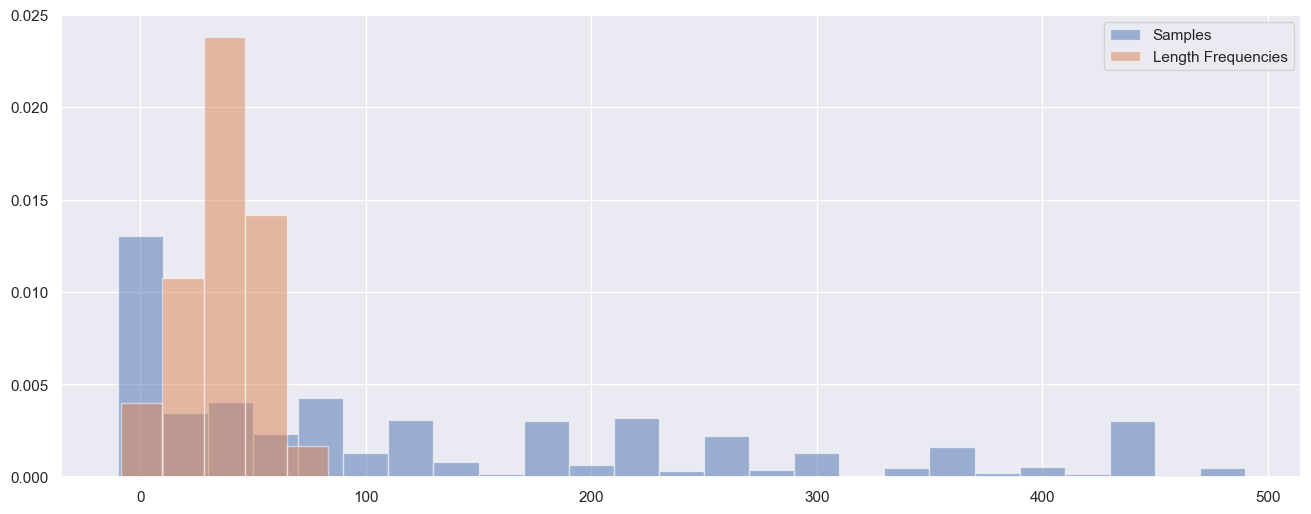

In [57]:
fig, ax = plt.subplots(figsize=(16, 6))
bins = 5
density = True

plt.hist(pd.DataFrame(df_SD.catch_kg), bins=bins*5, alpha=0.5, label='Samples', density=density, align='left', range=(0, 500))
plt.hist(pd.DataFrame(df_LF.groupby('id')['wt_kg'].max()), bins=bins, alpha=0.5, label='Length Frequencies', density=density, align='left')

plt.legend(loc='upper right')

plt.show()

# could expect 5%+ error rate based on zeros, and a few more from low percentiles

In [58]:
pd.DataFrame(df_LF.groupby('id')['wt_kg'].max()).reset_index()

,id,wt_kg
0,1990050712,NaN
1,1990050805,NaN
2,1990050908,NaN
3,1990051008,NaN
4,1990051048,NaN
...,...,...
912,4009052226,59.000
913,4010051126,16.300
914,4010051926,45.400
915,4010052726,54.900


In [59]:
QACHECK = pd.merge(
    df_SD[['id','catch_kg']],
    pd.DataFrame(df_LF.groupby('id')['wt_kg'].max()),
    on='id'
).rename(columns={'catch_kg': 'SD_count', 'wt_kg': 'LF_count'})

QACHECK['QA_RATIO'] = QACHECK['LF_count'] / QACHECK['SD_count']

QACHECK.describe()

,id,SD_count,LF_count,QA_RATIO
count,917.000,731.000,849.000,680.000
mean,2043610900.902,977.218,45.917,inf
std,253285736.021,1645.354,16.084,NaN
min,1990050712.000,0.000,0.500,0.004
25%,1995060541.000,181.400,36.700,0.053
50%,2003062026.000,362.900,44.900,0.115
75%,2014052121.000,907.200,57.600,0.269
max,4018061364.000,15000.300,92.500,inf


In [60]:
# 0.2% error rate, looks good, but let's look at a few in detail
QACHECK[QACHECK.QA_RATIO > 1].shape[0] / df_SD.id.nunique()

0.0020060829612373

In [61]:
QACHECK[QACHECK.QA_RATIO > 1]

,id,SD_count,LF_count,QA_RATIO
47,1991052112,68.000,68.500,1.007
84,1993052060,13.600,59.900,4.404
94,1993052660,45.400,57.600,1.269
111,1994051326,45.400,49.900,1.099
115,1994051617,0.000,43.500,inf
128,1994052517,0.000,11.300,inf
139,1995060137,45.400,49.900,1.099
143,1995052205,45.400,54.900,1.209
177,1998051417,22.700,58.500,2.577
200,1999051438,34.000,35.400,1.041


In [62]:
# check one random error at a time

# NOTES:
# these look like rounding errors, looks to match: 1994051326, 1995052205, 2016051415, 1991052112
# maybe typo? maybe mismatch?: 1993052060 
# overall: looks good, mostly rounding errors, and look like matches

rand_bad_id = np.random.choice(list(QACHECK[QACHECK.QA_RATIO > 1].id))
display(df_SD[df_SD.id == rand_bad_id])
display(df_LF[df_LF.id == rand_bad_id])
display(df_FD[df_FD.sample_id == rand_bad_id])

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,id
5263,2.000,SWMARG,Norman MacNeil,NaN,81.000,60,NaN,1993,5,20,4,30.000,13.600,NaN,upper,MacNeil,NaN,NaN,NaN,NaN,60,<NA>,1993-05-20,1993052060


,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,SITE1,SITE2,SITE3,id,new_sample,new_id,length_bin_id
1558,1993,5,20,NaN,SW MARGAREE,4,60,UPPER,AM,132.000,59.900,230,6,230,1993-05-20,60,<NA>,<NA>,1993052060,True,True,23.000
1559,1993,5,20,NaN,SW MARGAREE,4,60,UPPER,AM,132.000,59.900,235,15,235,1993-05-20,60,<NA>,<NA>,1993052060,False,False,23.500
1560,1993,5,20,NaN,SW MARGAREE,4,60,UPPER,AM,132.000,59.900,240,65,240,1993-05-20,60,<NA>,<NA>,1993052060,False,False,24.000
1561,1993,5,20,NaN,SW MARGAREE,4,60,UPPER,AM,132.000,59.900,245,59,245,1993-05-20,60,<NA>,<NA>,1993052060,False,False,24.500
1562,1993,5,20,NaN,SW MARGAREE,4,60,UPPER,AM,132.000,59.900,250,50,250,1993-05-20,60,<NA>,<NA>,1993052060,False,False,25.000
1563,1993,5,20,NaN,SW MARGAREE,4,60,UPPER,AM,132.000,59.900,255,37,255,1993-05-20,60,<NA>,<NA>,1993052060,False,False,25.500
1564,1993,5,20,NaN,SW MARGAREE,4,60,UPPER,AM,132.000,59.900,260,8,260,1993-05-20,60,<NA>,<NA>,1993052060,False,False,26.000
1565,1993,5,20,NaN,SW MARGAREE,4,60,UPPER,AM,132.000,59.900,265,11,265,1993-05-20,60,<NA>,<NA>,1993052060,False,False,26.500
1566,1993,5,20,NaN,SW MARGAREE,4,60,UPPER,AM,132.000,59.900,270,4,270,1993-05-20,60,<NA>,<NA>,1993052060,False,False,27.000
1567,1993,5,20,NaN,SW MARGAREE,4,60,UPPER,AM,132.000,59.900,275,2,275,1993-05-20,60,<NA>,<NA>,1993052060,False,False,27.500


,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME,SITE1,SITE2,SITE3,sample_id
10594,1993,5,20,<NA>,"60, 52",AM,Frozen,18,<NA>,265,273.000,245.000,A,F,5,30.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1993-05-20,60,52,<NA>,1993052060
10595,1993,5,20,<NA>,"60, 52",AM,Frozen,11,<NA>,265,273.000,248.000,A,F,5,32.300,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1993-05-20,60,52,<NA>,1993052060
10596,1993,5,20,<NA>,"60, 52",AM,Frozen,25,<NA>,265,273.000,259.000,A,F,5,42.100,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1993-05-20,60,52,<NA>,1993052060
10597,1993,5,20,<NA>,"60, 52",AM,Frozen,14,<NA>,243,251.000,200.000,A,M,4,30.000,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,1993-05-20,60,52,<NA>,1993052060
10598,1993,5,20,<NA>,"60, 52",AM,Frozen,29,<NA>,253,261.000,203.000,A,F,4,28.400,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,1993-05-20,60,52,<NA>,1993052060
10599,1993,5,20,<NA>,"60, 52",AM,Frozen,28,<NA>,260,268.000,243.000,A,M,5,41.600,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,1993-05-20,60,52,<NA>,1993052060
10600,1993,5,20,<NA>,"60, 52",AM,Frozen,15,<NA>,265,273.000,230.000,A,M,5,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1993-05-20,60,52,<NA>,1993052060
10601,1993,5,20,<NA>,"60, 52",AM,Frozen,13,<NA>,250,258.000,250.000,U,U,<NA>,NaN,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1993-05-20,60,52,<NA>,1993052060
10602,1993,5,20,<NA>,"60, 52",AM,Frozen,10,<NA>,248,256.000,218.000,A,M,4,28.300,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,1993-05-20,60,52,<NA>,1993052060
10603,1993,5,20,<NA>,"60, 52",AM,Frozen,7,<NA>,245,253.000,190.000,A,F,4,NaN,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,1993-05-20,60,52,<NA>,1993052060
